In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split, Subset
from torch.nn.utils.rnn import pad_sequence
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pickle


In [2]:
seed = 0
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(seed)

In [3]:

# Cargar las secuencias que son vectores de facenet de 128 dimensiones
carpetaDeceptive = Path("Data/Visual/facenet_128/Deceptive")
carpetaTruthful = Path("Data/Visual/facenet_128/Truthful")

video_d = []
video_t = []

etiquetas = []


for archivo in sorted(carpetaDeceptive.iterdir()):
    with archivo.open("r", encoding="utf-8") as f:
        df = pd.read_csv(f, sep=" ", header=None, usecols=range(128))  
        seq = df.values  # shape (T, 128)
        seq = (seq - seq.mean(axis=0)) / (seq.std(axis=0) + 1e-6)
        video_d.append(seq)
etiquetas = [0 for i in range(len(video_d))]

for archivo in sorted(carpetaTruthful.iterdir()):
    with archivo.open("r", encoding="utf-8") as f:
        df = pd.read_csv(f, sep=" ", header=None, usecols=range(128))  
        seq = df.values  # shape (T, 128)
        seq = (seq - seq.mean(axis=0)) / (seq.std(axis=0) + 1e-6)
        video_t.append(seq)
etiquetas += [1 for i in range(len(video_t))]
video = video_d + video_t
etiquetas = np.array(etiquetas)

In [4]:
data_idx = np.load("holdout_indices.npz")
dev_idx = data_idx["dev"]
test_idx = data_idx["test"]

print(len(dev_idx))
print(len(test_idx))


262
47


In [5]:
print(np.unique(etiquetas,return_counts=True))

(array([0, 1]), array([147, 162], dtype=int64))


In [6]:
class VideoDataset(Dataset):
    def __init__(self, sequences, labels):
        assert len(sequences) == len(labels)
        self.sequences = sequences
        self.labels    = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        seq_t = torch.tensor(seq, dtype=torch.float32)      # (T_i, 128)
        lbl_t = torch.tensor(self.labels[idx], dtype=torch.long)  # escalar
        return seq_t, lbl_t

def collate_fn(batch):
    seqs, labels = zip(*batch)
    padded_seqs = pad_sequence(seqs, batch_first=True, padding_value=0.0)  
    pad_mask = (padded_seqs.abs().sum(dim=-1) == 0)      
    labels = torch.stack(labels)     
    return padded_seqs, pad_mask, labels



In [7]:
def add_gaussian_noise(seq, sigma=0.01):
    return seq + torch.randn_like(seq) * sigma

def temporal_jitter(seq, max_shift=5):
    # desplaza la ventana de frames entre [−max_shift, +max_shift]
    shift = random.randint(-max_shift, max_shift)
    if shift > 0:
        return torch.cat([seq[shift:], seq[:shift]], dim=0)
    elif shift < 0:
        return torch.cat([seq[shift:], seq[:shift]], dim=0)
    else:
        return seq

def frame_dropout(seq, drop_prob=0.1):
    # elimina cada frame con probabilidad drop_prob (y rellena al final)
    keep = torch.rand(seq.size(0)) > drop_prob
    kept = seq[keep]
    # si queda vacío, al menos 1 frame
    if kept.numel() == 0:
        kept = seq[torch.randint(0, seq.size(0), (1,))]
    # pad al largo original
    pad_len = seq.size(0) - kept.size(0)
    if pad_len > 0:
        padding = torch.zeros(pad_len, seq.size(1), device=seq.device)
        kept = torch.cat([kept, padding], dim=0)
    return kept

class AugmentedVideoDataset(Dataset):
    def __init__(self, sequences, labels, augment=False):
        assert len(sequences) == len(labels)
        self.sequences = sequences
        self.labels    = labels
        self.augment   = augment

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = torch.tensor(self.sequences[idx], dtype=torch.float32)  # (T_i, 128)
        if self.augment:
            # aplica aleatoriamente cada técnica con probabilidad 0.5
            if random.random() < 0.5:
                seq = add_gaussian_noise(seq, sigma=0.02)
            if random.random() < 0.5:
                seq = temporal_jitter(seq, max_shift=10)
            if random.random() < 0.5:
                seq = frame_dropout(seq, drop_prob=0.1)
        lbl = torch.tensor(self.labels[idx], dtype=torch.long)
        return seq, lbl


In [8]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")

print(device)

cuda


In [9]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

def evaluar_modelo(model, test_loader, path, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    """
    Evalúa el modelo en test_loader cargando pesos desde 'path' y calcula varias métricas.

    Parámetros:
    - model: instancia de torch.nn.Module
    - test_loader: DataLoader con tu dataset de prueba
    - path: ruta al .pth con los pesos
    - device: dispositivo ('cpu' o 'cuda')
    - threshold: umbral para convertir probabilidades en etiquetas binaras
    """
    
    model.load_state_dict(torch.load(path, weights_only=True))
    model.to(device)
    model.eval()

    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        
        for x_batch, X_mask, y_batch in test_loader:
            x_batch = x_batch.to(device)
            X_mask = X_mask.to(device)
            y_batch = y_batch.to(device)
            logits = model(x_batch,X_mask)
            preds = logits.argmax(dim=1) 

            all_preds.append(preds.cpu())
            all_labels.append(y_batch.view(-1).cpu().long())

    all_preds  = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    acc    = accuracy_score(all_labels, all_preds)
    prec   = precision_score(all_labels, all_preds, zero_division=0)
    rec    = recall_score(all_labels, all_preds, zero_division=0)
    f1     = f1_score(all_labels, all_preds, zero_division=0)
    confm  = confusion_matrix(all_labels, all_preds)
    

    print(f"Total ejemplos en test: {len(all_labels)}")
    print(f"Accuracy:      {acc:.4f}")
    print(f"Precision:     {prec:.4f}")
    print(f"Recall:        {rec:.4f}")
    print(f"F1-score:      {f1:.4f}")
    print("Matriz de confusión:")
    print(confm)


In [10]:
class Transformer(nn.Module):
    def __init__(self, d_model=128, n_heads=2, num_layers=1,
                 dim_ff=256, max_len=1492):
        super().__init__()
        # Positional encoding aprendible
        self.pos_enc = nn.Parameter(torch.randn(1, max_len+1, d_model))
        # Token CLS que resume la secuencia
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_ff,
            dropout=0.5,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(d_model, 25),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(25, 2)       
        )
    
    def forward(self, x, mask=None):
        cls_out = self._get_cls_embedding(x, mask)
        logits = self.classifier(cls_out)
        return logits
    
    def _get_cls_embedding(self, x, mask=None):
        b, n, _ = x.size()
        cls = self.cls_token.expand(b, -1, -1)       
        x = torch.cat([cls, x], dim=1)              
        x = x + self.pos_enc[:, :n+1, :]             
        if mask is not None:
            mask = mask.bool()
            cls_mask = torch.zeros((b, 1),
                            dtype=torch.bool,
                            device=mask.device)
            mask = torch.cat([cls_mask, mask], dim=1) 
        out = self.encoder(x, src_key_padding_mask=mask)
        cls_out = out[:, 0, :]
        return cls_out
    
    def extract_features(self, x, mask=None):
        self.eval()  
        with torch.no_grad():
            features = self._get_cls_embedding(x, mask)
        return features

In [11]:
model = Transformer()
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Número de parámetros entrenables: {n_params:,}")

Número de parámetros entrenables: 326,989


c:\Users\ivan\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [12]:
def extract_features(model, loader, fold_idx):
    model = Transformer().to(device)
    model.load_state_dict(torch.load(f"models/video/best_model_fold{fold_idx+1}.pth"))
    model.eval()
   
    features = []
    labels = []

    with torch.no_grad():
        for X_batch, X_mask, y_batch in loader:
            X_batch = X_batch.to(device)
            X_mask = X_mask.to(device)
            f = model.extract_features(X_batch, X_mask) 
            features.append(f.cpu())
            labels.append(y_batch)  

    features = torch.cat(features, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    return features, labels

    



In [12]:

train_seqs = [video[i] for i in dev_idx]
test_seqs = [video[i] for i in test_idx]
train_labels = etiquetas[dev_idx]
test_labels = etiquetas[test_idx]



In [13]:

# Dataset para el entrenamiento
train_dataset = AugmentedVideoDataset(train_seqs, train_labels, augment=True)
train_dataset2 = AugmentedVideoDataset(train_seqs, train_labels, augment=False)

# Dataset apartado para el test, datos completamente nuevos
test_dataset = AugmentedVideoDataset(test_seqs, test_labels, augment=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [14]:
with open('fold_indices.pkl', 'rb') as f:
    folds = pickle.load(f)

In [15]:
print(len(folds))

5



--- Fold 1 ---
Epoch 001 | Tr Loss: 0.7098 Acc: 0.5215 | Val Loss: 0.6985 Acc: 0.4717
Mejores pesos guardados con precisión: 0.4717
Epoch 002 | Tr Loss: 0.6991 Acc: 0.5359 | Val Loss: 0.6952 Acc: 0.5283
Mejores pesos guardados con precisión: 0.5283
Epoch 003 | Tr Loss: 0.6947 Acc: 0.5311 | Val Loss: 0.6930 Acc: 0.5283
No mejora por 1/30 épocas
Epoch 004 | Tr Loss: 0.7067 Acc: 0.4785 | Val Loss: 0.6923 Acc: 0.5283
No mejora por 2/30 épocas
Epoch 005 | Tr Loss: 0.6866 Acc: 0.5646 | Val Loss: 0.6922 Acc: 0.5283
No mejora por 3/30 épocas
Epoch 006 | Tr Loss: 0.7076 Acc: 0.4306 | Val Loss: 0.6966 Acc: 0.4717
No mejora por 4/30 épocas
Epoch 007 | Tr Loss: 0.6930 Acc: 0.5407 | Val Loss: 0.6928 Acc: 0.5283
No mejora por 5/30 épocas
Epoch 008 | Tr Loss: 0.6905 Acc: 0.5215 | Val Loss: 0.6934 Acc: 0.5283
No mejora por 6/30 épocas
Epoch 009 | Tr Loss: 0.6953 Acc: 0.4785 | Val Loss: 0.6961 Acc: 0.4717
No mejora por 7/30 épocas
Epoch 010 | Tr Loss: 0.6925 Acc: 0.5215 | Val Loss: 0.6943 Acc: 0.4717


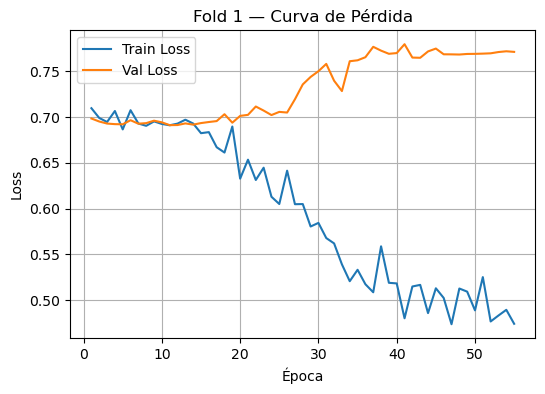

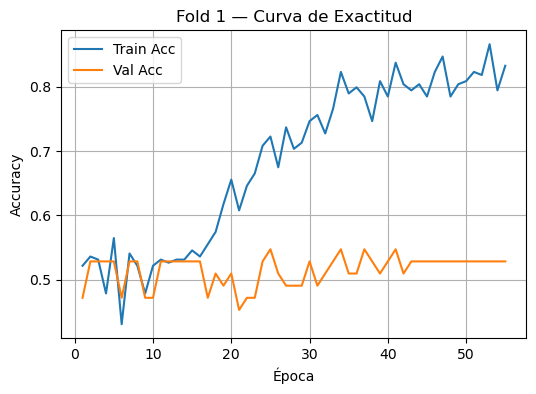

c:\Users\ivan\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
C:\Users\ivan\AppData\Local\Temp\ipykernel_7868\194248295.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for


--- Fold 2 ---
Epoch 001 | Tr Loss: 0.7632 Acc: 0.4833 | Val Loss: 0.6908 Acc: 0.5283
Mejores pesos guardados con precisión: 0.5283
Epoch 002 | Tr Loss: 0.6906 Acc: 0.5455 | Val Loss: 0.6912 Acc: 0.5283
No mejora por 1/30 épocas
Epoch 003 | Tr Loss: 0.6974 Acc: 0.5407 | Val Loss: 0.6950 Acc: 0.4717
No mejora por 2/30 épocas
Epoch 004 | Tr Loss: 0.6941 Acc: 0.5072 | Val Loss: 0.6949 Acc: 0.4717
No mejora por 3/30 épocas
Epoch 005 | Tr Loss: 0.6912 Acc: 0.4880 | Val Loss: 0.6972 Acc: 0.4717
No mejora por 4/30 épocas
Epoch 006 | Tr Loss: 0.6878 Acc: 0.5407 | Val Loss: 0.6968 Acc: 0.4528
No mejora por 5/30 épocas
Epoch 007 | Tr Loss: 0.6882 Acc: 0.5550 | Val Loss: 0.6985 Acc: 0.5283
No mejora por 6/30 épocas
Epoch 008 | Tr Loss: 0.6902 Acc: 0.5550 | Val Loss: 0.7001 Acc: 0.4906
No mejora por 7/30 épocas
Epoch 009 | Tr Loss: 0.6929 Acc: 0.5167 | Val Loss: 0.6939 Acc: 0.4717
No mejora por 8/30 épocas
Epoch 010 | Tr Loss: 0.6755 Acc: 0.5455 | Val Loss: 0.6992 Acc: 0.5283
No mejora por 9/30 é

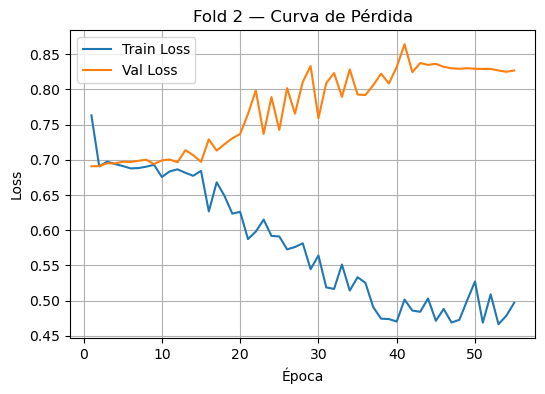

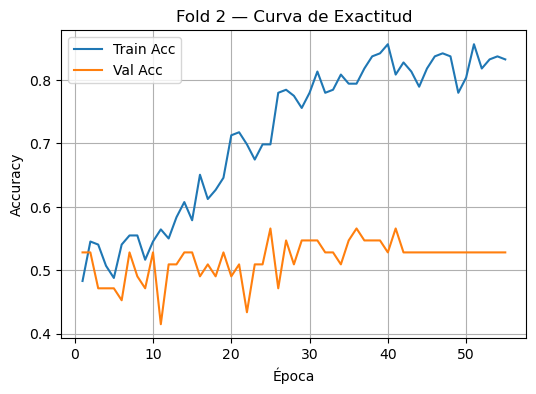


--- Fold 3 ---
Epoch 001 | Tr Loss: 0.7262 Acc: 0.4810 | Val Loss: 0.7093 Acc: 0.4808
Mejores pesos guardados con precisión: 0.4808
Epoch 002 | Tr Loss: 0.7036 Acc: 0.5286 | Val Loss: 0.6942 Acc: 0.5192
Mejores pesos guardados con precisión: 0.5192
Epoch 003 | Tr Loss: 0.7055 Acc: 0.4714 | Val Loss: 0.6927 Acc: 0.5192
No mejora por 1/30 épocas
Epoch 004 | Tr Loss: 0.6998 Acc: 0.4476 | Val Loss: 0.6914 Acc: 0.5192
No mejora por 2/30 épocas
Epoch 005 | Tr Loss: 0.6879 Acc: 0.5000 | Val Loss: 0.6921 Acc: 0.5192
No mejora por 3/30 épocas
Epoch 006 | Tr Loss: 0.6969 Acc: 0.5095 | Val Loss: 0.6930 Acc: 0.5192
No mejora por 4/30 épocas
Epoch 007 | Tr Loss: 0.6912 Acc: 0.5095 | Val Loss: 0.6930 Acc: 0.5192
No mejora por 5/30 épocas
Epoch 008 | Tr Loss: 0.6880 Acc: 0.5190 | Val Loss: 0.6928 Acc: 0.5192
No mejora por 6/30 épocas
Epoch 009 | Tr Loss: 0.6947 Acc: 0.5238 | Val Loss: 0.6958 Acc: 0.4808
No mejora por 7/30 épocas
Epoch 010 | Tr Loss: 0.6966 Acc: 0.4667 | Val Loss: 0.6953 Acc: 0.5192


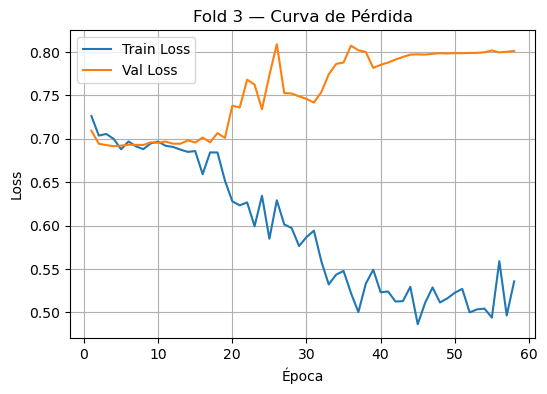

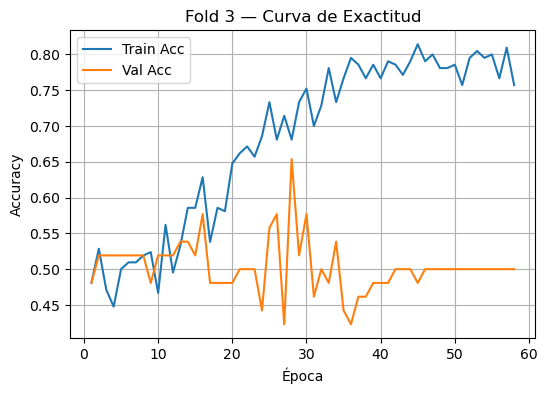


--- Fold 4 ---
Epoch 001 | Tr Loss: 0.7359 Acc: 0.5048 | Val Loss: 0.6963 Acc: 0.4808
Mejores pesos guardados con precisión: 0.4808
Epoch 002 | Tr Loss: 0.7106 Acc: 0.4619 | Val Loss: 0.6944 Acc: 0.5192
Mejores pesos guardados con precisión: 0.5192
Epoch 003 | Tr Loss: 0.7030 Acc: 0.4476 | Val Loss: 0.6959 Acc: 0.4423
No mejora por 1/30 épocas
Epoch 004 | Tr Loss: 0.6877 Acc: 0.5762 | Val Loss: 0.7065 Acc: 0.4423
No mejora por 2/30 épocas
Epoch 005 | Tr Loss: 0.6918 Acc: 0.5762 | Val Loss: 0.7041 Acc: 0.4615
No mejora por 3/30 épocas
Epoch 006 | Tr Loss: 0.6967 Acc: 0.5048 | Val Loss: 0.6998 Acc: 0.4615
No mejora por 4/30 épocas
Epoch 007 | Tr Loss: 0.6827 Acc: 0.5667 | Val Loss: 0.7120 Acc: 0.4615
No mejora por 5/30 épocas
Epoch 008 | Tr Loss: 0.6763 Acc: 0.5619 | Val Loss: 0.7221 Acc: 0.5000
No mejora por 6/30 épocas
Epoch 009 | Tr Loss: 0.6649 Acc: 0.6000 | Val Loss: 0.7228 Acc: 0.4423
No mejora por 7/30 épocas
Epoch 010 | Tr Loss: 0.6486 Acc: 0.5714 | Val Loss: 0.7569 Acc: 0.5192


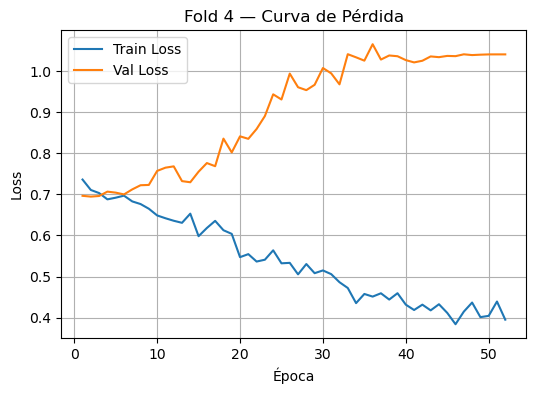

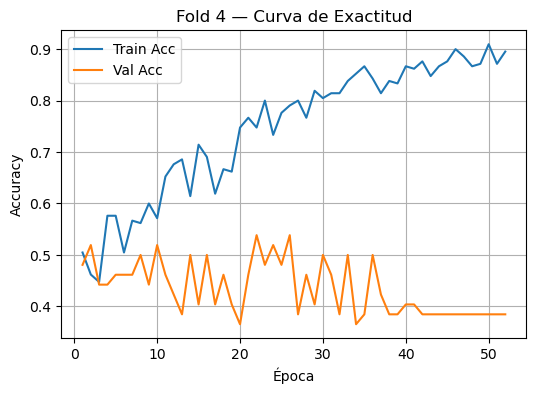


--- Fold 5 ---
Epoch 001 | Tr Loss: 0.7326 Acc: 0.4333 | Val Loss: 0.6924 Acc: 0.5192
Mejores pesos guardados con precisión: 0.5192
Epoch 002 | Tr Loss: 0.7049 Acc: 0.4524 | Val Loss: 0.6930 Acc: 0.4808
No mejora por 1/30 épocas
Epoch 003 | Tr Loss: 0.7033 Acc: 0.4857 | Val Loss: 0.6949 Acc: 0.4808
No mejora por 2/30 épocas
Epoch 004 | Tr Loss: 0.7028 Acc: 0.4619 | Val Loss: 0.6933 Acc: 0.4808
No mejora por 3/30 épocas
Epoch 005 | Tr Loss: 0.6915 Acc: 0.5048 | Val Loss: 0.6915 Acc: 0.5385
Mejores pesos guardados con precisión: 0.5385
Epoch 006 | Tr Loss: 0.6930 Acc: 0.5238 | Val Loss: 0.6937 Acc: 0.4808
No mejora por 1/30 épocas
Epoch 007 | Tr Loss: 0.7037 Acc: 0.5143 | Val Loss: 0.6931 Acc: 0.5192
No mejora por 2/30 épocas
Epoch 008 | Tr Loss: 0.6933 Acc: 0.5238 | Val Loss: 0.6926 Acc: 0.4615
No mejora por 3/30 épocas
Epoch 009 | Tr Loss: 0.6972 Acc: 0.5190 | Val Loss: 0.6931 Acc: 0.4808
No mejora por 4/30 épocas
Epoch 010 | Tr Loss: 0.6986 Acc: 0.5143 | Val Loss: 0.6930 Acc: 0.5577


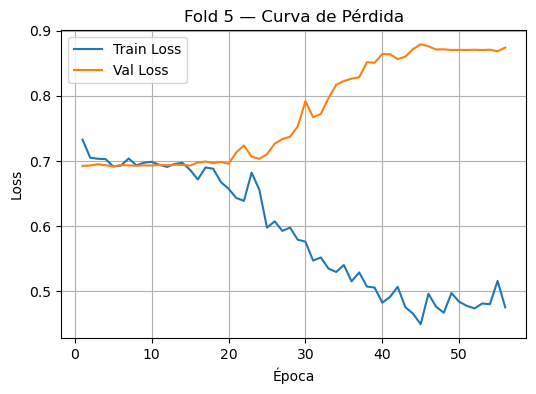

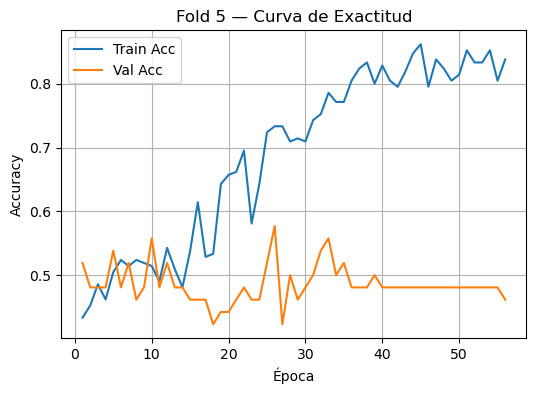

In [17]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

batch_size = 8
patience = 30
num_epochs = 100
fold_scores = []

all_dev_features = []
all_dev_labels = []

for fold, (train_idx_fold, val_idx_fold) in enumerate(folds):
    train_losses, train_accs = [], []
    val_losses,   val_accs   = [], []



    print(f"\n--- Fold {fold+1} ---")
    # Subsets 
    train_subset = Subset(train_dataset, train_idx_fold)
    val_subset = Subset(train_dataset2, val_idx_fold)

    # DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

   

    # Crear el modelo y los hyperparámetros
    model = Transformer().to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1) 
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)
    scheduler2 = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)


    best_acc, no_improve = 0.0, 0


    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for data in train_loader:
            X_batch, X_mask, y_batch = data
            X_batch = X_batch.to(device)
            X_mask = X_mask.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            logits = model(X_batch, X_mask)  
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * y_batch.size(0)
            preds = logits.argmax(dim=1)
            correct     += (preds == y_batch).sum().item()
            total       += y_batch.size(0)


        epoch_train_loss = running_loss / total
        epoch_train_acc  = correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)     

        model.eval()
        running_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for x_batch, mask, y_batch in val_loader:
                x_batch = x_batch.to(device)
                x_mask = mask.to(device)
                y_batch = y_batch.to(device)
                
                logits = model(x_batch,x_mask)
                loss = criterion(logits, y_batch)
                running_loss += loss.item() * y_batch.size(0)
                preds = logits.argmax(dim=1) 
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        epoch_val_loss = running_loss / total
        epoch_val_acc  = correct / total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        #scheduler.step(epoch_val_acc)

        print(f"Epoch {epoch:03d} | "
              f"Tr Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            torch.save(model.state_dict(), f"models/video/best_model_fold{fold+1}.pth")
            no_improve = 0  # reinicia el contador
            print(f"Mejores pesos guardados con precisión: {best_acc:.4f}")
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f" ↳ Early stopping tras {patience} épocas sin mejora")
                break

            print(f"No mejora por {no_improve}/{patience} épocas")
        scheduler2.step()
    fold_scores.append(best_acc)
    
    epochs = range(1, len(train_losses) + 1)

    # Pérdida
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses,   label='Val Loss')
    plt.title(f'Fold {fold+1} — Curva de Pérdida')
    plt.xlabel('Época'); plt.ylabel('Loss')
    plt.legend(); plt.grid(True)
    plt.show()

    # Exactitud
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_accs, label='Train Acc')
    plt.plot(epochs, val_accs,   label='Val Acc')
    plt.title(f'Fold {fold+1} — Curva de Exactitud')
    plt.xlabel('Época'); plt.ylabel('Accuracy')
    plt.legend(); plt.grid(True)
    plt.show()
    
    feats, labs = extract_features(model, val_loader, fold)
    all_dev_features.append(feats)
    all_dev_labels.append(labs)




In [18]:
all_dev_features = np.concatenate(all_dev_features, axis=0)
all_dev_labels = np.concatenate(all_dev_labels, axis=0)

print(all_dev_features.shape)
print(all_dev_labels.shape)

np.savez("final_features/dev/video_features_and_labels.npz", features=all_dev_features, labels=all_dev_labels)

(262, 128)
(262,)


In [19]:
print(f"\nAcc validación: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
best_fold = int(np.argmax(fold_scores))
print(f"Mejor fold: {best_fold+1} con precisión: {fold_scores[best_fold]:.4f}")



Acc validación: 0.5765 ± 0.0410
Mejor fold: 3 con precisión: 0.6538


In [20]:
model = Transformer()
evaluar_modelo(model,test_loader, path=f"models/video/best_model_fold{best_fold+1}.pth")

Total ejemplos en test: 47
Accuracy:      0.6170
Precision:     0.5897
Recall:        0.9200
F1-score:      0.7188
Matriz de confusión:
[[ 6 16]
 [ 2 23]]


In [21]:
model = Transformer().to(device)
test_features, test_labels = extract_features(model, test_loader, best_fold)
np.savez("final_features/test/video_features_and_labels.npz", features=test_features, labels=test_labels)

c:\Users\ivan\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
C:\Users\ivan\AppData\Local\Temp\ipykernel_7868\194248295.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for

In [16]:
model = Transformer().to(device)


In [20]:
evaluar_modelo(model,test_loader, path=f"models/video/best_model_fold1.pth")

Total ejemplos en test: 47
Accuracy:      0.5106
Precision:     0.5263
Recall:        0.8000
F1-score:      0.6349
Matriz de confusión:
[[ 4 18]
 [ 5 20]]


In [21]:
evaluar_modelo(model,test_loader, path=f"models/video/best_model_fold2.pth")

Total ejemplos en test: 47
Accuracy:      0.4255
Precision:     0.4500
Recall:        0.3600
F1-score:      0.4000
Matriz de confusión:
[[11 11]
 [16  9]]


In [22]:
evaluar_modelo(model,test_loader, path=f"models/video/best_model_fold3.pth")

Total ejemplos en test: 47
Accuracy:      0.6170
Precision:     0.5897
Recall:        0.9200
F1-score:      0.7188
Matriz de confusión:
[[ 6 16]
 [ 2 23]]


In [23]:
evaluar_modelo(model,test_loader, path=f"models/video/best_model_fold4.pth")

Total ejemplos en test: 47
Accuracy:      0.4468
Precision:     0.4828
Recall:        0.5600
F1-score:      0.5185
Matriz de confusión:
[[ 7 15]
 [11 14]]


In [24]:
evaluar_modelo(model,test_loader, path=f"models/video/best_model_fold5.pth")

Total ejemplos en test: 47
Accuracy:      0.3617
Precision:     0.3913
Recall:        0.3600
F1-score:      0.3750
Matriz de confusión:
[[ 8 14]
 [16  9]]
